In [38]:
using LaTeXStrings
using StatsPlots
using PrettyTables
using Distributions
using StatsBase
using Corpuscles
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using LinearAlgebra
using JLD2
#pyplot()
#gr()
#theme(:gruvbox_dark)

In [2]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

print("ss has ")
print(length(fileList_ss))
print(" files, bb has ")
print(length(fileList_bb))
print(" files, cc has ")
print(length(fileList_cc))
print(" files, gg has ")
print(length(fileList_gg))
print(" files")
sampleList=Dict()
sampleList["ss"]=fileList_ss
sampleList["bb"]=fileList_bb
sampleList["cc"]=fileList_cc
sampleList["gg"]=fileList_gg

ss has 100 files, bb has 100 files, cc has 100 files, gg has 100 files

100-element Array{String,1}:
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.0_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.10_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.11_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.12_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.13_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.14_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.15_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel/E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8.pR0.3.16_DST.slcio"
 "/nfs/dust/ilc/user/jstrube/Strange

In [3]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2- #it gives me negative arguement so im giving abs for now
        dot(getMomentum(particle_1)+getMomentum(particle_2), 
            getMomentum(particle_1)+getMomentum(particle_2))+10^(-5))
    return a
end

function invMassSumSquared(particle_1, particle_2)
    a = (getEnergy(particle_1)+getEnergy(particle_2))^2-dot(getMomentum(particle_1)+getMomentum(particle_2), getMomentum(particle_1)+getMomentum(particle_2))
    return a
end
    
function invMass(particle)
    return sqrt(getEnergy(particle)^2-dot(getMomentum(particle), getMomentum(particle))+10^(-5))
end
    

function recoil_mass(μ₁, μ₂)
    E_initial = 250.0  #can update to make it accurate for the event's flucation, with p as well?
    px_initial = 0.0
    recoilE = E_initial - getEnergy(μ₁) - getEnergy(μ₂)
    recoilP = [px_initial, 0, 0] - getMomentum(μ₁) - getMomentum(μ₂)
    return sqrt(recoilE^2 - sum(recoilP.^2)+10^(-5)) #it gives me negative arguement so im giving abs for now
end
    
function recoil_mass_squared(μ₁, μ₂)
    E_initial = 250.0  #can update to make it accurate for the event's flucation, with p as well?
    px_initial = 0.0
    recoilE = E_initial - getEnergy(μ₁) - getEnergy(μ₂)
    recoilP = [px_initial, 0, 0] - getMomentum(μ₁) - getMomentum(μ₂)
    return recoilE^2 - sum(recoilP.^2)+10^(-5) #it gives me negative arguement so im giving abs for now
end

recoil_mass_squared (generic function with 1 method)

In [4]:
function zMuonIndices(event, threshold, MCTruth=false) #for certain events it returns an empty candidatePairs
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    
    if MCTruth==false
        collection = getCollection(event, "PandoraPFOs")
        for particle in collection
            iParticle += 1
            if abs(getType(particle))==13 #|| abs(getType(particle))==211 #&& getGeneratorStatus(particle)==1 #assuming all pfos are final state
                if getCharge(particle)==1
                    push!(posMuonList, (particle, iParticle))
                elseif getCharge(particle)==-1
                    push!(negMuonList, (particle, iParticle))
                end
            end
        end
        
    elseif MCTruth==true
        collection = getCollection(event, "MCParticle")
        for particle in collection
            iParticle += 1
            if abs(getPDG(particle))==13 && getGeneratorStatus(particle)==1
                if getCharge(particle)==1
                    push!(posMuonList, (particle, iParticle))
                elseif getCharge(particle)==-1
                    push!(negMuonList, (particle, iParticle))
                end
            end
        end      
    end

    
    candidatePair=[0,0]
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    if abs(candidateDiff)>threshold
        indices=[0,0]
    elseif length(candidatePair)>0
         indices = [candidatePair[1][2], candidatePair[2][2]]
    end
    return indices
end

function trueZMuonFinder(event)
    
    nZ=0
    muons=[]
    mcCollection = getCollection(event, "MCParticle")
    for (iParticle, particle) in enumerate(mcCollection)
        if abs(getPDG(particle))==13 && getGeneratorStatus(particle)==1
            muonParent=false
            for parent in getParents(particle)
                if abs(getPDG(parent))==13 && muonParent==false
                    push!(muons, particle)
                    muonParent=true
                    break
                end
            end
        end
    end
    return muons
end
        

trueZMuonFinder (generic function with 1 method)

perSampleFalsePosIndex = Dict()
perSamplePurity = Dict()
perSampleNoParents = Dict()
perSampleRecoPDG = Dict()
differenceList = Dict()
recoilMass = Dict()
efficiencyList=Dict()
nEvent=Dict()
zMass = Dict()
zMassTruth = Dict()
nTwoReco = Dict()

In [41]:
@load "FalsePosIndex"
@load "NoParents"
@load "RecoPDG"
@load "DifferenceList"
@load "nEvents"
@load "Purity"
@load "Efficiencies"
@load "RecoilMass" #JDL2 isnt loading this but it worked before and the correct plot is below
@load "zMassReco"
@load "zMassTruth"
@load "nTwoReco"
@load "TwoRecoMuonsPerEvent"
@load "BestEfficieny"
@load "TwoRecoPerTwoMC"
@load "nEventsWithZ"
@load "mcEfficient"
@load "TwoRecoPerTwoReconstructable"

1-element Array{Symbol,1}:
 :twoRecoPerTwoReconstructable

In [57]:
@time for sample in [fileList_ss]
    iSkip=0
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[] #im gonna assume all have parents so im gonna remove the code for checking
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    zMassPerSample = []
    zMassTruthPerSample = []
    zMassMC = []
    nZ=0
    nMuonsMC=0
    nRecoPartners=0
    nEventWithRecoMuons=0
    baseEfficient=0
    nEventsTwoPlusReconstructables=0
    nEventsTwoRecosInList=0
    for FILENAME in sample
#       if iFile>2
 #           break
  #      end
        iFile+=1
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            falsePos=false
            missingRecoMuon=false
            notInList=false
            haveEvent=false
            for event in reader
 #               if iEvent>10
  #                  break
   #             end
                iEvent+=1
                
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10) #im going to cut out the mc index and collection line, just making note
                mcMuons=trueZMuonFinder(event)
                if length(mcMuons)==2
                    nZ+=1
                    nMuonsMC+=length(mcMuons)
                    if invMassSumSquared(mcMuons[1], mcMuons[2])>convert(Float64, 0.0)
                        push!(zMassTruthPerSample, invMassSum(mcMuons[1], mcMuons[2]))
                    else
                        iSkip+=1
                        continue
                    end
                end
#                else
#                    if haveEvent==false
 #                       for (iParticle, particle) in enumerate(getCollection(event, "MCParticle"))
  #                          print(getPDG(particle))
   #                     end
    #                    haveEvent=true
     #               end
                #print(zMuonIndex)
    
                recoMuons=[]
                for (iParticle, particle) in enumerate(collection) #cutting out getToo, this is note
                    if iParticle in RP_zMuonIndex
                        push!(recoMuons, particle)
                        push!(recoPDG, getType(particle))
                    end
                end
            
            
                reconstructableMuons=[]
                rpM1=getRelatedFromObjects(rel, mcMuons[1])
                rpM2=getRelatedFromObjects(rel, mcMuons[2])
                rpM=[rpM1, rpM2]
                if length(rpM1)>0 && length(rpM2)>0
                    for rp in rpM
                        if getCharge(rp[1])!=0
                            nRecoPartners+=1
                        end
                        for muon in rp
                            push!(reconstructableMuons, muon)
                        end
                    end
                elseif length(rpM1)==0 || length(rpM2)==0
                    missingRecoMuon=true
                end
                
                if length(rpM1)>0 && length(rpM2)>0
                    nEventsTwoPlusReconstructables+=1
                    nIn=0
                    if length(reconstructableMuons)>1
                        for muon in recoMuons
                            same=false
                            if muon in reconstructableMuons
                                nIn+=1
                            else
                                falsePos=true
                                nFalsePos+=1
                            end
                        end
                        if nIn==2
                            nEventsTwoRecosInList+=1
                        end 
                    end
                end
                
                if length(recoMuons)>0
                    nEventWithRecoMuons+=1
                    if length(recoMuons)==2
                        if recoil_mass_squared(recoMuons[1], recoMuons[2])>convert(Float64, 0.0)
                            push!(perSampleRecoilMass, recoil_mass(recoMuons[1], recoMuons[2])) #why is this negative?
                        else
                            iSkip+=1
                            continue
                        end
                        if invMassSumSquared(recoMuons[1], recoMuons[2])>0.0
                            push!(zMassPerSample, invMassSum(recoMuons[1], recoMuons[2]))
                        else
                            iSkip+=1
                            continue
                        end
                        if length(mcMuons)==2
                            if invMassSum(mcMuons[1], mcMuons[2])>0.0
                                push!(perSampleDifferenceList, invMassSum(recoMuons[1], recoMuons[2])-invMassSum(mcMuons[1], mcMuons[2]))
                            else
                                iSkip+=1
                                continue
                            end
                        end
                    end
                end
                

                if falsePos==true
                   push!(falsePosEventIndexList, (iFile, iEvent))
                end
                if missingRecoMuon==false
                    baseEfficient+=1
                end
                
            end
            push!(perFilePurity, 1-nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["ss"] = falsePosEventIndexList
    perSamplePurity["ss"] = mean(perFilePurity)
    perSampleNoParents["ss"] = mean(perFileNoParents)
    perSampleRecoPDG["ss"] = recoPDG
    differenceList["ss"] = perSampleDifferenceList
    recoilMass["ss"] = perSampleRecoilMass
    zMass["ss"] = zMassPerSample
    zMassTruth["ss"] = zMassTruthPerSample
    nTwoReco["ss"] = nEventWithRecoMuons
    bestEfficiency["ss"]=nRecoPartners/nMuonsMC
    nEventsWithZ["ss"]=nZ
    twoRecoPerTwoReconstructable["ss"]=nEventWithRecoMuons/nEventsTwoPlusReconstructables
    nSkip["ss"]=iSkip
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
    @save "zMassReco" zMass
    @save "zMassTruth" zMassTruth
    @save "nTwoReco" nTwoReco
    @save "BestEfficieny" bestEfficiency
    @save "nEventsWithZ" nEventsWithZ
    @save "TwoRecoPerTwoReconstructable" twoRecoPerTwoReconstructable
    @save "nSkip" nSkip
end

421.032705 seconds (200.14 M allocations: 6.082 GiB, 0.47% gc time)


In [58]:
@time for sample in [fileList_bb]
    iSkip=0
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[] #im gonna abbume all have parents so im gonna remove the code for checking
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    zMassPerSample = []
    zMassTruthPerSample = []
    zMassMC = []
    nZ=0
    nMuonsMC=0
    nRecoPartners=0
    nEventWithRecoMuons=0
    baseEfficient=0
    nEventsTwoPlusReconstructables=0
    nEventsTwoRecosInList=0
    for FILENAME in sample
#       if iFile>2
 #           break
  #      end
        iFile+=1
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            falsePos=false
            missingRecoMuon=false
            notInList=false
            haveEvent=false
            for event in reader
 #               if iEvent>10
  #                  break
   #             end
                iEvent+=1
                
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10) #im going to cut out the mc index and collection line, just making note
                mcMuons=trueZMuonFinder(event)
                if length(mcMuons)==2
                    nZ+=1
                    nMuonsMC+=length(mcMuons)
                    if invMassSumSquared(mcMuons[1], mcMuons[2])>convert(Float64, 0.0)
                        push!(zMassTruthPerSample, invMassSum(mcMuons[1], mcMuons[2]))
                    else
                        iSkip+=1
                        continue
                    end
                end
#                else
#                    if haveEvent==false
 #                       for (iParticle, particle) in enumerate(getCollection(event, "MCParticle"))
  #                          print(getPDG(particle))
   #                     end
    #                    haveEvent=true
     #               end
                #print(zMuonIndex)
    
                recoMuons=[]
                for (iParticle, particle) in enumerate(collection) #cutting out getToo, this is note
                    if iParticle in RP_zMuonIndex
                        push!(recoMuons, particle)
                        push!(recoPDG, getType(particle))
                    end
                end
            
            
                reconstructableMuons=[]
                rpM1=getRelatedFromObjects(rel, mcMuons[1])
                rpM2=getRelatedFromObjects(rel, mcMuons[2])
                rpM=[rpM1, rpM2]
                if length(rpM1)>0 && length(rpM2)>0
                    for rp in rpM
                        if getCharge(rp[1])!=0
                            nRecoPartners+=1
                        end
                        for muon in rp
                            push!(reconstructableMuons, muon)
                        end
                    end
                elseif length(rpM1)==0 || length(rpM2)==0
                    missingRecoMuon=true
                end
                
                if length(rpM1)>0 && length(rpM2)>0
                    nEventsTwoPlusReconstructables+=1
                    nIn=0
                    if length(reconstructableMuons)>1
                        for muon in recoMuons
                            same=false
                            if muon in reconstructableMuons
                                nIn+=1
                            else
                                falsePos=true
                                nFalsePos+=1
                            end
                        end
                        if nIn==2
                            nEventsTwoRecosInList+=1
                        end 
                    end
                end
                
                if length(recoMuons)>0
                    nEventWithRecoMuons+=1
                    if length(recoMuons)==2
                        if recoil_mass_squared(recoMuons[1], recoMuons[2])>convert(Float64, 0.0)
                            push!(perSampleRecoilMass, recoil_mass(recoMuons[1], recoMuons[2])) #why is this negative?
                        else
                            iSkip+=1
                            continue
                        end
                        if invMassSumSquared(recoMuons[1], recoMuons[2])>0.0
                            push!(zMassPerSample, invMassSum(recoMuons[1], recoMuons[2]))
                        else
                            iSkip+=1
                            continue
                        end
                        if length(mcMuons)==2
                            if invMassSum(mcMuons[1], mcMuons[2])>0.0
                                push!(perSampleDifferenceList, invMassSum(recoMuons[1], recoMuons[2])-invMassSum(mcMuons[1], mcMuons[2]))
                            else
                                iSkip+=1
                                continue
                            end
                        end
                    end
                end
                

                if falsePos==true
                   push!(falsePosEventIndexList, (iFile, iEvent))
                end
                if missingRecoMuon==false
                    baseEfficient+=1
                end
                
            end
            push!(perFilePurity, 1-nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["bb"] = falsePosEventIndexList
    perSamplePurity["bb"] = mean(perFilePurity)
    perSampleNoParents["bb"] = mean(perFileNoParents)
    perSampleRecoPDG["bb"] = recoPDG
    differenceList["bb"] = perSampleDifferenceList
    recoilMass["bb"] = perSampleRecoilMass
    zMass["bb"] = zMassPerSample
    zMassTruth["bb"] = zMassTruthPerSample
    nTwoReco["bb"] = nEventWithRecoMuons
    bestEfficiency["bb"]=nRecoPartners/nMuonsMC
    nEventsWithZ["bb"]=nZ
    twoRecoPerTwoReconstructable["bb"]=nEventWithRecoMuons/nEventsTwoPlusReconstructables
    nSkip["bb"]=iSkip
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
    @save "zMassReco" zMass
    @save "zMassTruth" zMassTruth
    @save "nTwoReco" nTwoReco
    @save "BestEfficieny" bestEfficiency
    @save "nEventsWithZ" nEventsWithZ
    @save "TwoRecoPerTwoReconstructable" twoRecoPerTwoReconstructable
    @save "nSkip" nSkip
end


452.668964 seconds (220.70 M allocations: 6.686 GiB, 0.55% gc time)


In [59]:
@time for sample in [fileList_cc]
    iSkip=0
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[] #im gonna accume all have parents so im gonna remove the code for checking
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    zMassPerSample = []
    zMassTruthPerSample = []
    zMassMC = []
    nZ=0
    nMuonsMC=0
    nRecoPartners=0
    nEventWithRecoMuons=0
    baseEfficient=0
    nEventsTwoPlusReconstructables=0
    nEventsTwoRecosInList=0
    for FILENAME in sample
#       if iFile>2
 #           break
  #      end
        iFile+=1
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            falsePos=false
            missingRecoMuon=false
            notInList=false
            haveEvent=false
            for event in reader
 #               if iEvent>10
  #                  break
   #             end
                iEvent+=1
                
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10) #im going to cut out the mc index and collection line, just making note
                mcMuons=trueZMuonFinder(event)
                if length(mcMuons)==2
                    nZ+=1
                    nMuonsMC+=length(mcMuons)
                    if invMassSumSquared(mcMuons[1], mcMuons[2])>convert(Float64, 0.0)
                        push!(zMassTruthPerSample, invMassSum(mcMuons[1], mcMuons[2]))
                    else
                        iSkip+=1
                        continue
                    end
                end
#                else
#                    if haveEvent==false
 #                       for (iParticle, particle) in enumerate(getCollection(event, "MCParticle"))
  #                          print(getPDG(particle))
   #                     end
    #                    haveEvent=true
     #               end
                #print(zMuonIndex)
    
                recoMuons=[]
                for (iParticle, particle) in enumerate(collection) #cutting out getToo, this is note
                    if iParticle in RP_zMuonIndex
                        push!(recoMuons, particle)
                        push!(recoPDG, getType(particle))
                    end
                end
            
            
                reconstructableMuons=[]
                rpM1=getRelatedFromObjects(rel, mcMuons[1])
                rpM2=getRelatedFromObjects(rel, mcMuons[2])
                rpM=[rpM1, rpM2]
                if length(rpM1)>0 && length(rpM2)>0
                    for rp in rpM
                        if getCharge(rp[1])!=0
                            nRecoPartners+=1
                        end
                        for muon in rp
                            push!(reconstructableMuons, muon)
                        end
                    end
                elseif length(rpM1)==0 || length(rpM2)==0
                    missingRecoMuon=true
                end
                
                if length(rpM1)>0 && length(rpM2)>0
                    nEventsTwoPlusReconstructables+=1
                    nIn=0
                    if length(reconstructableMuons)>1
                        for muon in recoMuons
                            same=false
                            if muon in reconstructableMuons
                                nIn+=1
                            else
                                falsePos=true
                                nFalsePos+=1
                            end
                        end
                        if nIn==2
                            nEventsTwoRecosInList+=1
                        end 
                    end
                end
                
                if length(recoMuons)>0
                    nEventWithRecoMuons+=1
                    if length(recoMuons)==2
                        if recoil_mass_squared(recoMuons[1], recoMuons[2])>convert(Float64, 0.0)
                            push!(perSampleRecoilMass, recoil_mass(recoMuons[1], recoMuons[2])) #why is this negative?
                        else
                            iSkip+=1
                            continue
                        end
                        if invMassSumSquared(recoMuons[1], recoMuons[2])>0.0
                            push!(zMassPerSample, invMassSum(recoMuons[1], recoMuons[2]))
                        else
                            iSkip+=1
                            continue
                        end
                        if length(mcMuons)==2
                            if invMassSum(mcMuons[1], mcMuons[2])>0.0
                                push!(perSampleDifferenceList, invMassSum(recoMuons[1], recoMuons[2])-invMassSum(mcMuons[1], mcMuons[2]))
                            else
                                iSkip+=1
                                continue
                            end
                        end
                    end
                end
                

                if falsePos==true
                   push!(falsePosEventIndexList, (iFile, iEvent))
                end
                if missingRecoMuon==false
                    baseEfficient+=1
                end
                
            end
            push!(perFilePurity, 1-nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["cc"] = falsePosEventIndexList
    perSamplePurity["cc"] = mean(perFilePurity)
    perSampleNoParents["cc"] = mean(perFileNoParents)
    perSampleRecoPDG["cc"] = recoPDG
    differenceList["cc"] = perSampleDifferenceList
    recoilMass["cc"] = perSampleRecoilMass
    zMass["cc"] = zMassPerSample
    zMassTruth["cc"] = zMassTruthPerSample
    nTwoReco["cc"] = nEventWithRecoMuons
    bestEfficiency["cc"]=nRecoPartners/nMuonsMC
    nEventsWithZ["cc"]=nZ
    twoRecoPerTwoReconstructable["cc"]=nEventWithRecoMuons/nEventsTwoPlusReconstructables
    nSkip["cc"]=iSkip
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
    @save "zMassReco" zMass
    @save "zMassTruth" zMassTruth
    @save "nTwoReco" nTwoReco
    @save "BestEfficieny" bestEfficiency
    @save "nEventsWithZ" nEventsWithZ
    @save "TwoRecoPerTwoReconstructable" twoRecoPerTwoReconstructable
    @save "nSkip" nSkip
end


446.512040 seconds (209.60 M allocations: 6.362 GiB, 0.47% gc time)


In [60]:
@time for sample in [fileList_gg]
    iSkip=0
    iFile=0
    recoPDG=[]
    falsePosEventIndexList=[]
    zMuonPurityList=[]
    perFilePurity=[]
    noParentIndexList=[]
    perFileNoParents=[] #im gonna aggume all have parents so im gonna remove the code for checking
    perSampleRecoMuonMassList = []
    perSampleMcMuonMassList = []
    perSampleDifferenceList = []
    perSampleRecoilMass = []
    zMassPerSample = []
    zMassTruthPerSample = []
    zMassMC = []
    nZ=0
    nMuonsMC=0
    nRecoPartners=0
    nEventWithRecoMuons=0
    baseEfficient=0
    nEventsTwoPlusReconstructables=0
    nEventsTwoRecosInList=0
    for FILENAME in sample
#       if iFile>2
 #           break
  #      end
        iFile+=1
        LCIO.open(FILENAME) do reader
            iEvent=0
            nFalsePos=0
            nNoParents=0
            falsePos=false
            missingRecoMuon=false
            notInList=false
            haveEvent=false
            for event in reader
 #               if iEvent>10
  #                  break
   #             end
                iEvent+=1
                
                collection = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RP_zMuonIndex = zMuonIndices(event, 10) #im going to cut out the mc index and collection line, just making note
                mcMuons=trueZMuonFinder(event)
                if length(mcMuons)==2
                    nZ+=1
                    nMuonsMC+=length(mcMuons)
                    if invMassSumSquared(mcMuons[1], mcMuons[2])>convert(Float64, 0.0)
                        push!(zMassTruthPerSample, invMassSum(mcMuons[1], mcMuons[2]))
                    else
                        iSkip+=1
                        continue
                    end
                end
#                else
#                    if haveEvent==false
 #                       for (iParticle, particle) in enumerate(getCollection(event, "MCParticle"))
  #                          print(getPDG(particle))
   #                     end
    #                    haveEvent=true
     #               end
                #print(zMuonIndex)
    
                recoMuons=[]
                for (iParticle, particle) in enumerate(collection) #cutting out getToo, this is note
                    if iParticle in RP_zMuonIndex
                        push!(recoMuons, particle)
                        push!(recoPDG, getType(particle))
                    end
                end
            
            
                reconstructableMuons=[]
                rpM1=getRelatedFromObjects(rel, mcMuons[1])
                rpM2=getRelatedFromObjects(rel, mcMuons[2])
                rpM=[rpM1, rpM2]
                if length(rpM1)>0 && length(rpM2)>0
                    for rp in rpM
                        if getCharge(rp[1])!=0
                            nRecoPartners+=1
                        end
                        for muon in rp
                            push!(reconstructableMuons, muon)
                        end
                    end
                elseif length(rpM1)==0 || length(rpM2)==0
                    missingRecoMuon=true
                end
                
                if length(rpM1)>0 && length(rpM2)>0
                    nEventsTwoPlusReconstructables+=1
                    nIn=0
                    if length(reconstructableMuons)>1
                        for muon in recoMuons
                            same=false
                            if muon in reconstructableMuons
                                nIn+=1
                            else
                                falsePos=true
                                nFalsePos+=1
                            end
                        end
                        if nIn==2
                            nEventsTwoRecosInList+=1
                        end 
                    end
                end
                
                if length(recoMuons)>0
                    nEventWithRecoMuons+=1
                    if length(recoMuons)==2
                        if recoil_mass_squared(recoMuons[1], recoMuons[2])>convert(Float64, 0.0)
                            push!(perSampleRecoilMass, recoil_mass(recoMuons[1], recoMuons[2])) #why is this negative?
                        else
                            iSkip+=1
                            continue
                        end
                        if invMassSumSquared(recoMuons[1], recoMuons[2])>0.0
                            push!(zMassPerSample, invMassSum(recoMuons[1], recoMuons[2]))
                        else
                            iSkip+=1
                            continue
                        end
                        if length(mcMuons)==2
                            if invMassSum(mcMuons[1], mcMuons[2])>0.0
                                push!(perSampleDifferenceList, invMassSum(recoMuons[1], recoMuons[2])-invMassSum(mcMuons[1], mcMuons[2]))
                            else
                                iSkip+=1
                                continue
                            end
                        end
                    end
                end
                

                if falsePos==true
                   push!(falsePosEventIndexList, (iFile, iEvent))
                end
                if missingRecoMuon==false
                    baseEfficient+=1
                end
                
            end
            push!(perFilePurity, 1-nFalsePos/iEvent)
            push!(perFileNoParents, nNoParents/iEvent)
        end
    end
    perSampleFalsePosIndex["gg"] = falsePosEventIndexList
    perSamplePurity["gg"] = mean(perFilePurity)
    perSampleNoParents["gg"] = mean(perFileNoParents)
    perSampleRecoPDG["gg"] = recoPDG
    differenceList["gg"] = perSampleDifferenceList
    recoilMass["gg"] = perSampleRecoilMass
    zMass["gg"] = zMassPerSample
    zMassTruth["gg"] = zMassTruthPerSample
    nTwoReco["gg"] = nEventWithRecoMuons
    bestEfficiency["gg"]=nRecoPartners/nMuonsMC
    nEventsWithZ["gg"]=nZ
    twoRecoPerTwoReconstructable["gg"]=nEventWithRecoMuons/nEventsTwoPlusReconstructables
    nSkip["gg"]=iSkip
    
    @save "FalsePosIndex" perSampleFalsePosIndex
    @save "Purity" perSamplePurity
    @save "NoParents" perSampleNoParents
    @save "RecoPDG" perSampleRecoPDG
    @save "DifferenceList" differenceList
    @save "RecoilMass" recoilMass
    @save "zMassReco" zMass
    @save "zMassTruth" zMassTruth
    @save "nTwoReco" nTwoReco
    @save "BestEfficieny" bestEfficiency
    @save "nEventsWithZ" nEventsWithZ
    @save "TwoRecoPerTwoReconstructable" twoRecoPerTwoReconstructable
    @save "nSkip" nSkip
end


281.152648 seconds (149.73 M allocations: 4.468 GiB, 0.56% gc time)


In [ ]:
@time for key in keys(sampleList)
    iEvent=0
    for FILENAME in sampleList[key]
        LCIO.open(FILENAME) do reader
            iEvent+=length(reader)
        end
    end
    nEvent[key]=iEvent
end
@save "nEvents" nEvent

In [61]:
nSkip

Dict{Any,Any} with 4 entries:
  "ss" => 0
  "bb" => 1
  "gg" => 0
  "cc" => 0

In [62]:
efficiencyList=Dict()
for key in keys(differenceList)
    efficiencyList[key]=length(differenceList[key])/nEvent[key]
end
@save "Efficiencies" efficiencyList

twoRecoMuonsPerEvent=Dict()
for key in keys(nTwoReco)
    twoRecoMuonsPerEvent[key] = nTwoReco[key]/nEvent[key]
end
@save "TwoRecoMuonsPerEvent" twoRecoMuonsPerEvent

twoRecoPerTwoMC=Dict()
for key in keys(differenceList)
    twoRecoPerTwoMC[key] = length(recoilMass[key])/length(differenceList[key])
end
@save "TwoRecoPerTwoMC" twoRecoPerTwoMC

mcEfficient=Dict()
for key in keys(nEventsWithZ)
    mcEfficient[key] = nEventsWithZ[key]/nEvent[key]
end
@save "mcEfficient" mcEfficient

To Do:\
Normalize plots?\
Dont use getRelatedTooObjects for Reco - for pdg use abs(getType(pfo)==13)\
Check efficiencies of only one muon\
Dont require 2 MC Muons for efficiency calc\
Look at efficiencies with a difference z threshold\
Create a function for getting true z daughters\

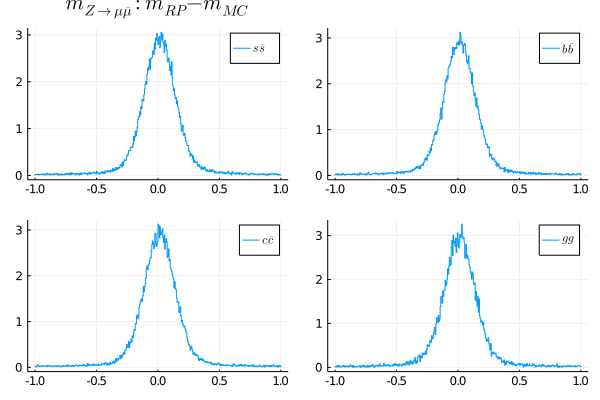

In [145]:
difflist=plot(
    plot(seriestype=:stephist, differenceList["ss"], label=L"s\bar{s}", norm=true, bins=-1:0.005:1, title=L"m_{Z \rightarrow \mu \bar{\mu}}: m_{RP} \minus m_{MC}"),
    plot(seriestype=:stephist, differenceList["bb"], label=L"b\bar{b}", norm=true, bins=-1:0.005:1),
    plot(seriestype=:stephist, differenceList["cc"], label=L"c\bar{c}", norm=true, bins=-1:0.005:1),
    plot(seriestype=:stephist, differenceList["gg"], label=L"gg", norm=true, bins=-1:0.005:1),
    layout=(2,2))
#same formatting things from recoil plots
#savefig("differenceListNoPion.pdf")

In [158]:
plot(seriestype=:stephist, differenceList["ss"], label=L"s\bar{s}", norm=true, bins=-1:0.01:1, 
    title=L"m_{Z \rightarrow \mu \bar{\mu}}: m_{RP} \minus m_{MC}",
    xlabel=L"\textrm{Mass Difference} \frac{GeV}{c^2}",
    ylabel=L"\textrm{Frequency}"
)
plot!(seriestype=:stephist, differenceList["bb"], label=L"b\bar{b}", norm=true, bins=-1:0.01:1)
plot!(seriestype=:stephist, differenceList["cc"], label=L"c\bar{c}", norm=true, bins=-1:0.01:1)
plot!(seriestype=:stephist, differenceList["gg"], label=L"gg", norm=true, bins=-1:0.01:1)
savefig("differenceListNoPion.pdf")

In [98]:
pretty_table(hcat([key for key in keys(perSamplePurity)], [round(perSamplePurity[key], digits=3) for key in keys(perSamplePurity)]), 
    ["Event Type", "Purity"], backend=:latex)

\begin{tabular}{rr}
\hline\hline
\textbf{Event Type} & \textbf{Purity} \\\hline
ss & 1.0 \\
bb & 0.998 \\
gg & 1.0 \\
cc & 1.0 \\\hline\hline
\end{tabular}


Base.KeySet for a Dict{Any,Any} with 4 entries. Keys:
  "ss"
  "bb"
  "gg"
  "cc"

In [106]:
labels=[L"s\bar{s}", L"b\bar{b}", L"c\bar{c}", "gg"]
pretty_table(hcat([key for key in labels], [round(efficiencyList[key], digits=3) for key in keys(bestEfficiency)], [round(bestEfficiency[key], digits=3) for key in keys(bestEfficiency)]), 
    ["Event Type", "Reco Efficiency", "Optimal Efficiency"], backend=:latex)

 #lower than expectation, due to bug that fails call a muon a muon, 
            #becomes closer to whats expected when looking at pions, get that number, 
        #check charged reco efficiency (muon or pion), should be around 80%
#about 90% of charged particles are reconstructed, 95%-99% of those muons are called muons IRL

\begin{tabular}{rrr}
\hline\hline
\textbf{Event Type} & \textbf{Reco Efficiency} & \textbf{Optimal Efficiency} \\\hline
$s\bar{s}$ & 0.589 & 0.816 \\
$b\bar{b}$ & 0.588 & 0.816 \\
$c\bar{c}$ & 0.582 & 0.814 \\
gg & 0.587 & 0.817 \\\hline\hline
\end{tabular}


In [70]:
twoRecoMuonsPerEvent

Dict{Any,Any} with 4 entries:
  "ss" => 0.588715
  "bb" => 0.588105
  "gg" => 0.58204
  "cc" => 0.586653

In [113]:
pretty_table(hcat([key for key in labels], 
        [round(perSamplePurity[key], digits=3) for key in keys(perSamplePurity)],
        [round(twoRecoPerTwoMC[key], digits=3) for key in keys(twoRecoPerTwoMC)], 
        [round(mcEfficient[key], digits=3) for key in keys(mcEfficient)], 
        [nEvent[key] for key in keys(nEvent)]), 
    ["Event Type", "Purity", "2 PFO muons/2 MC muons", "MC Efficiency", "nEvents"], backend=:latex)

#twoRecoPerTwoMC #this, purity (use per sample efficiency method), nEvents, and below are a slide

\begin{tabular}{rrrrr}
\hline\hline
\textbf{Event Type} & \textbf{Purity} & \textbf{2 PFO muons/2 MC muons} & \textbf{MC Efficiency} & \textbf{nEvents} \\\hline
$s\bar{s}$ & 1.0 & 1.0 & 1.0 & 96500 \\
$b\bar{b}$ & 0.998 & 1.0 & 1.0 & 95500 \\
$c\bar{c}$ & 1.0 & 1.0 & 1.0 & 50000 \\
gg & 1.0 & 1.0 & 1.0 & 96500 \\\hline\hline
\end{tabular}


In [107]:
mcEfficient

Dict{Any,Any} with 4 entries:
  "ss" => 1.0
  "bb" => 1.0
  "gg" => 1.0
  "cc" => 1.0

In [101]:
pretty_table(hcat([key for key in keys(bestEfficiency)], [round(bestEfficiency[key], digits=3) for key in keys(bestEfficiency)], [nEvent[key] for key in keys(nEvent)]), 
    ["Event Type", "2 PFO muons/nEvents", "nEvents"], backend=:latex)

bestEfficiency #the actual reco efficiency, % of MC muons that get reconstructed by detector #this is a slide

Dict{Any,Any} with 4 entries:
  "ss" => 0.815575
  "bb" => 0.815696
  "gg" => 0.81364
  "cc" => 0.816642

In [74]:
twoRecoPerTwoReconstructable #irrelevant for actual experiment, relevant towards making the algorithm, dont include

Dict{Any,Any} with 4 entries:
  "ss" => 0.600958
  "bb" => 0.600421
  "gg" => 0.596389
  "cc" => 0.59905

In [ ]:
for key in keys(perSampleRecoPDG)
    print(key)
    print(": ")
    print(string(sum(abs.(perSampleRecoPDG[key]).!=13)/nTwoReco[key])) #% of all that dont=13
    print(", ")
end

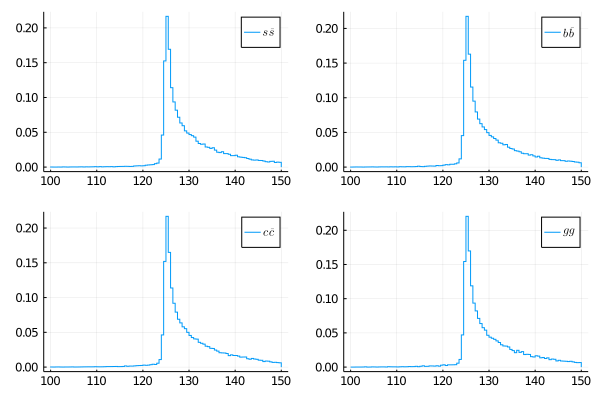

In [78]:
plot(
    plot(seriestype=:stephist, recoilMass["ss"], label=L"s\bar{s}", norm=true, bins=100:0.5:150),
    plot(seriestype=:stephist, recoilMass["bb"], label=L"b\bar{b}", norm=true, bins=100:0.5:150),
    plot(seriestype=:stephist, recoilMass["cc"], label=L"c\bar{c}", norm=true, bins=100:0.5:150),
    plot(seriestype=:stephist, recoilMass["gg"], label=L"gg", norm=true, bins=100:0.5:150),
    layout=(2,2),
    figtitle="Recoil Mass"
    
) #add labels, try to make them universal

In [ ]:
nEvent

In [ ]:
perSampleFalsePosIndex #only have it for gg right now but the code for any sample is there

In [86]:
plot(seriestype=:stephist, recoilMass["ss"], label=L"s\bar{s}", norm=true, bins=100:0.5:150, ylabel=L"\textrm{Frequency}", xlabel=L"\textrm{Recoil Mass} \frac{GeV}{c^{2}}")
plot!(seriestype=:stephist, recoilMass["bb"], label=L"b\bar{b}", norm=true, bins=100:0.5:150)
plot!(seriestype=:stephist, recoilMass["cc"], label=L"c\bar{c}", norm=true, bins=100:0.5:150)
plot!(seriestype=:stephist, recoilMass["gg"], label=L"gg", norm=true, bins=100:0.5:150)
savefig("recoilMassNoPion.pdf")
    #add labels, try to make them universal

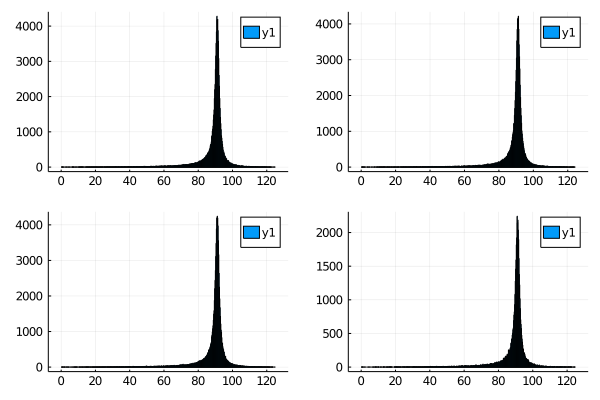

In [76]:
plot(
    histogram(zMassTruth["ss"]),
    histogram(zMassTruth["bb"]),
    histogram(zMassTruth["cc"]),
    histogram(zMassTruth["gg"])
    ) #format

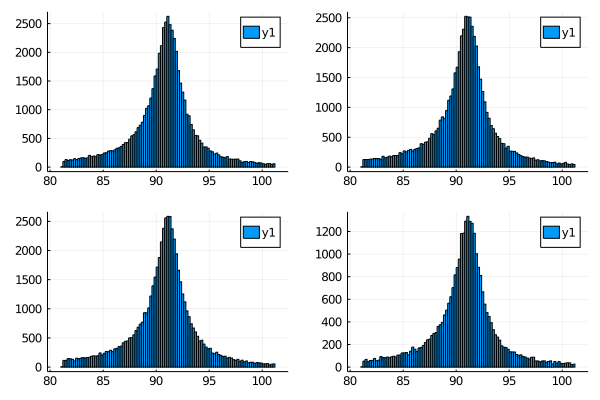

In [77]:
plot(
    histogram(zMass["ss"]),
    histogram(zMass["bb"]),
    histogram(zMass["cc"]),
    histogram(zMass["gg"])
    ) #format